# Coursera Capstone Project The Battle of Neighborhood
This is the final project in the IBM Data Science course in Coursera. In this project the student should realize an own idea with geo location information.
## Idea of this notebook
In this notebook it should be searched the best neighborhood of Toronto to live as a bicyclist. For this reason it will be used the data from the last week to explore the location in Toronto. To get bicycle related data it should be used Openstreetmap to scrap data.
## What are bicycle related?
The first step is to determine which information can be used
* length of bicycle lanes
* amount of public parks
* amount of destinations for cyclist
* amount of bicycle workshops, shops for spare parts
* squarefeet of puplic parks

## Getting data
The data should be got from Open Street Map. This is a open source project and there are several APIs to get information.

In [1]:
!pip3 install OSMPythonTools
!pip3 install osm2geojson
!pip3 install shapely

In [2]:
import pandas as pd
import numpy as np
import json
import requests # library to handle requests
from OSMPythonTools.overpass import Overpass
ovp = Overpass()
from OSMPythonTools.api import Api
api = Api()
import osm2geojson
from shapely.geometry import Polygon

In [225]:
def SortNode(ways):
    index = 0
    sortidx = 0
    while sortidx < (len(ways) - 1):
        ways_idx = ways[sortidx + 1].copy()
        ways_idx_rev = ways[sortidx + 1].copy()
        ways_idx_rev.reverse()
        #print(f'sortidx: {sortidx}\r\n')   
        #print(f'ways[{sortidx}]: {ways[sortidx]}\r\nways[{sortidx + 1}]: {ways[sortidx + 1]}\r\n')
        #print(f'ways_idx: {ways_idx}\r\nways_idx_rev: {ways_idx_rev}\r\n')
        #print(f'ways[{sortidx}][-1]: {ways[sortidx][-1]}\r\nways_idx[0]: {ways_idx[0]}\r\n')
        #print(f'ways[{sortidx}][-1]: {ways[sortidx][-1]}\r\nways_idx_rev[0]: {ways_idx_rev[0]}\r\n')
        if ways[sortidx][-1] == ways_idx[0]:
            sortidx = sortidx + 1
        elif ways[sortidx][-1] == ways_idx_rev[0]:
            ways[sortidx + 1] = ways_idx_rev
            sortidx = sortidx + 1
        else:
            index = sortidx + 2
            if index >= len(ways):
                index = 0
            while index != 1:
                ways_idx = ways[index].copy()
                ways_idx_rev = ways[index].copy()
                ways_idx_rev.reverse()
                #print(f'index: {index}\r\n')
                #print(f'ways[{sortidx}]: {ways[sortidx]}\r\nways[{index}]: {ways[index]}\r\n')
                #print(f'ways_idx: {ways_idx}\r\n')
                #print(f'ways_idx_rev: {ways_idx_rev}\r\n')
                #print(f'ways[{sortidx}][-1]: {ways[sortidx][-1]}\r\nways_idx[0]: {ways_idx[0]}\r\n')
                #print(f'ways[{sortidx}][-1]: {ways[sortidx][-1]}\r\nways_idx_rev[0]: {ways_idx_rev[0]}\r\n')
                if ways[sortidx][-1] == ways_idx[0]:
                    ways.pop(index);
                    ways.insert(sortidx + 1, ways_idx)
                    sortidx = 0
                    index = 1
                    break
                elif ways[sortidx][-1] == ways_idx_rev[0]:
                    ways.pop(index);
                    ways.insert(sortidx + 1, ways_idx_rev)
                    sortidx = 0
                    index = 1
                    break
                else:
                    index = index + 1
                    if index >= len(ways):
                        index = 0
            sortidx = sortidx + 1

    #print(f'ways[0]: {ways[0]}\r\nways[1]: {ways[1]}\r\n')
    #print(f'ways after: {ways}\r\n')
    return ways

def OverpassQuery(query):
    result_w = ovp.query(query, timeout=100)
    res_json = result_w.toJSON()
    res_elements = res_json['elements']
    #print(f'res_json:\r\n{res_json}\r\n')
    #print(f'type(res_json):\r\n{type(res_json)}\r\n')
    #print(f'res_json.keys:\r\n{res_json.keys()}\r\n')
    return res_elements

In [260]:
#search_query = f'relation["boundary"="administrative"]["name"="Don Valley West"];way(r);out qt;'
borough = ["Scarborough", "North York", "Old Toronto", "Etobicoke", "York", "East York"]

Scarborough_query = f'area[name="Toronto"];relation["boundary"="administrative"]["name"="{borough[0]}"](area);way(r);out qt;'
North_York_query = f'area[name="Toronto"];relation["boundary"="administrative"]["name"="{borough[1]}"](area);way(r);out qt;'
Old_Toronto_query = f'area[name="Toronto"];relation["boundary"="administrative"]["name"="{borough[2]}"](area);way(r);out qt;'
Etobicoke_query = f'area[name="Toronto"];relation["boundary"="administrative"]["name"="{borough[3]}"](area);way(r);out qt;'
York_query = f'area[name="Toronto"];relation["boundary"="administrative"]["name"="{borough[4]}"](area);way(r);out qt;'
East_Yorkh_query = f'area[name="Toronto"];relation["boundary"="administrative"]["name"="{borough[5]}"](area);way(r);out qt;'
#search_query = f'relation["boundary"="administrative"]["name"="Don Valley West"];way(r);out geom qt;'
#search_query = f'relation["boundary"="administrative"]["name"="Don Valley West"];out qt;>;out skel qt;'

queries = [Scarborough_query, North_York_query, Old_Toronto_query, Etobicoke_query, York_query, East_Yorkh_query]
overpass_response = []
for x in queries:
    tmp = OverpassQuery(x).copy()
    overpass_response.append(tmp)

ways = []
for y in overpass_response:
    #print(f'y: {y}\r\n')
    #print(f'new_overpass_query\r\n')

    ways_inner = []
    for x in y:
        #print(f'x: {x}\r\n')
        ways_inner.append(x['nodes'])

    ways.append(ways_inner)


node_list = []
for x in ways:
    #print(f'ways(x) before: {x}\r\n')
    x = SortNode(x)
    #print(f'ways(x) after: {x}\r\n')

ways_coordinates = []
for w in ways:
    ways_coordinates_inner = []
    for x in w:
        #print(f'x: {x}\r\n')
        #print(f'api.query({x})\r\n')
        result_ways = api.query(f'node/{x}')
        #result_ways = ovp.query(f'node["id"="{x}"]({latitude - bbox_off},{longitude - bbox_off},{latitude + bbox_off},{longitude + bbox_off});out;', timeout=100)
        #print(f'result_ways.lat: {result_ways.lat()}\r\nresult_ways.lon: {result_ways.lon()}\r\n')
        ways_coordinates_inner.append([result_ways.lat(),result_ways.lon()])
        node_list.append([result_ways.lat(),result_ways.lon()])
        #print(f'ways_cor_inner: {ways_cor_inner}\r\n')
        #print(f'type(ways_cor): {type(ways_cor_inner)}\r\n')
    ways_coordinates.append(ways_coordinates_inner)
    #print(f'ways_cor: {ways_cor}\r\n')
    #print(f'type(ways_cor): {type(ways_cor_inner)}\r\n')
df_nodes_lat = pd.DataFrame(node_list).iloc[:,0]
df_nodes_lon = pd.DataFrame(node_list).iloc[:,1]
#print(f'df_nodes_lat: {df_nodes_lat}\r\n')
#print(f'df_nodes_lon: {df_nodes_lon}\r\n')


[api] downloading data: node/[1978509957, 598211030, 598211041, 598211040, 598211039, 598211038, 598211037, 598211036, 6251712581]
The requested data could not be downloaded.  Please check whether your internet connection is working.
Traceback (most recent call last):
  File "d:\programme\anaconda3\lib\site-packages\OSMPythonTools\internal\cacheObject.py", line 83, in __query
    response = urllib.request.urlopen(request)
  File "d:\programme\anaconda3\lib\urllib\request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "d:\programme\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "d:\programme\anaconda3\lib\urllib\request.py", line 542, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "d:\programme\anaconda3\lib\urllib\request.py", line 502, in _call_chain
    result = func(*args)
  File "d:\programme\anaconda3\lib\urllib\request.py", line 1379, in http_open
    return self.do

ways(x) before: [[1978509957, 598211030, 598211041, 598211040, 598211039, 598211038, 598211037, 598211036, 6251712581], [2337285720, 2337285723, 2337285725, 2337285729, 2337285727, 2337285732, 2337285734, 258499439], [1978509957, 2337285720], [3096972158, 264108466, 3708757618, 3404820938, 5360098182, 8027152251, 36155608, 3383818206, 264107835, 152135566, 264108200, 264820439, 264108211, 264108418, 2882545341, 72305405, 6640972841, 830820663, 6640972852, 6640972835, 7616930064, 25768674, 7616930060, 7616930059, 4597721836, 1336191875, 258499439], [6251715021, 1978509965, 1978509962, 424058258, 32419703, 2826468710, 4442068450, 266439880, 3584722644, 3584722643, 266440041, 3584722642, 3584722640, 3584722638, 424052656, 424052658, 1612628929, 4326912490, 265866877, 4326912489, 265868754, 1612615864, 265867695, 2853067165, 3486751185, 265868762, 3486751181, 265868739, 265868486, 423042442, 265868446, 423042447, 421873411, 6601779193, 265868496, 4326922088, 25768665, 4326922087, 443600078

Exception: The requested data could not be downloaded.  Please check whether your internet connection is working.

In [248]:
#tmp['Neighbourhood']
import folium # map rendering library

map_select = folium.Map(location=[latitude, longitude], zoom_start=16)

#folium.GeoJson(
 #   result_geo,
  #  name='geojson'
#).add_to(map_select)
#for x in ways_cor:
#    folium.PolyLine(x, color='red').add_to(map_select)

#for x in ways_cor:
#    folium.Polygon(x, fill = True, fill_color='blue').add_to(map_select)

#folium.Polygon(ways_cor, fill = True, fill_color='blue').add_to(map_select)

folium.PolyLine(node_list, fill = True, fill_color='blue').add_to(map_select)

#for x in node_list:
    #folium.Circle(x, fill = True, fill_color='blue').add_to(map_select)

#folium.LayerControl().add_to(map_select)

# add markers to map
#for lat, lng, borough, neighborhood in zip(tmp['Latitude'], tmp['Longitude'], tmp['Borough'], tmp['Neighbourhood']):
#    label = '{}, {}'.format(neighborhood, borough)
#    label = folium.Popup(label, parse_html=True)
#    folium.CircleMarker(
#        [lat, lng],
#        radius=5,
#        popup=label,
#        color='blue',
#        fill=True,
#        fill_color='#3186cc',
#        fill_opacity=0.7,
#        parse_html=False).add_to(map_select)  
#{latitude - bbox_off},{longitude - bbox_off},{latitude + bbox_off},{longitude + bbox_off}
#map_select.fit_bounds([[latitude - bbox_off, longitude - bbox_off], [latitude + bbox_off, longitude + bbox_off]]) 
map_select.fit_bounds([[df_nodes_lat.min(), df_nodes_lon.min()], [df_nodes_lat.max(), df_nodes_lon.max()]]) 
map_select

In [206]:

#from bs4 import BeautifulSoup
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
results = requests.get(url)

#print(results.text)

#soup = BeautifulSoup(results.text, 'html.parser')

#table = soup.find_all('table')[0] 
#df = pd.read_html(str(table))

dfs = pd.read_html(results.text, header=0)[0]
dfs

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In [178]:
dfs = dfs[dfs['Borough'] != "Not assigned"]
dfs

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [202]:
bor = dfs.groupby(by=['Borough']).count()
bor

,Postal Code,Neighbourhood
Borough,,
Central Toronto,9,9
Downtown Toronto,19,19
East Toronto,5,5
East York,5,5
Etobicoke,12,12
Mississauga,1,1
North York,24,24
Scarborough,17,17
West Toronto,6,6


In [191]:
geo = pd.read_csv("Geospatial_Coordinates.csv")
geo

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [192]:
tmp = dfs.copy()
#tmp.loc[tmp['Postal Code'] == geo['Postal Code'], 'Latitude'] = geo['Latitude']
for index in geo['Postal Code']:
    for index2 in tmp['Postal Code']:
        if index == index2:
            #print(f'Index: {index}, Index2: {index2}')
            #print(geo.loc[geo['Postal Code'] == index, 'Longitude'])
            tmp.loc[tmp['Postal Code'] == index2, 'Longitude'] = geo.loc[geo['Postal Code'] == index, 'Longitude'].values
            tmp.loc[tmp['Postal Code'] == index2, 'Latitude'] = geo.loc[geo['Postal Code'] == index, 'Latitude'].values
            #print(tmp.loc[tmp['Postal Code'] == index2, 'Longitude'])
            #print(tmp.loc[tmp['Postal Code'] == index2, 'Latitude'])
            
    #tmp.loc[tmp['Postal Code'] == index, 'Longitude'] = geo['Longitude']    
tmp.reset_index(drop=True, inplace=True)
tmp

,Postal Code,Borough,Neighbourhood,Longitude,Latitude
0,M3A,North York,Parkwoods,-79.329656,43.753259
1,M4A,North York,Victoria Village,-79.315572,43.725882
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",-79.360636,43.654260
3,M6A,North York,"Lawrence Manor, Lawrence Heights",-79.464763,43.718518
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",-79.389494,43.662301
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",-79.506944,43.653654
99,M4Y,Downtown Toronto,Church and Wellesley,-79.383160,43.665860
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",-79.321558,43.662744
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",-79.498509,43.636258


In [193]:
tmp['Neighbourhood']
import folium # map rendering library
latitude = 43.725950
longitude = -79.338393
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(tmp['Latitude'], tmp['Longitude'], tmp['Borough'], tmp['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [194]:
CLIENT_ID = 'T2ZKTOONYGDDUG1R1VZOYG0T1CKLK3F5Q1DF1W0OPX1Q4EIP' # your Foursquare ID
CLIENT_SECRET = 'V5APV4N12QPNOEE1JTSIRGYV0DCOMOTR5F4KTPOTCVM4TLQ5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: T2ZKTOONYGDDUG1R1VZOYG0T1CKLK3F5Q1DF1W0OPX1Q4EIP
CLIENT_SECRET:V5APV4N12QPNOEE1JTSIRGYV0DCOMOTR5F4KTPOTCVM4TLQ5


In [11]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

NameError: name 'manhattan_data' is not defined

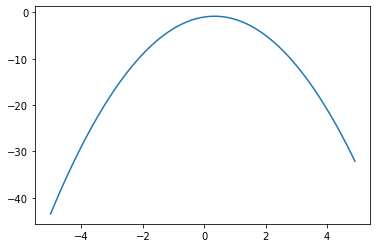

In [419]:
import matplotlib.pyplot as plt
x = np.array(range(-50, 50, 1))/10
y = -3/2*(x*x) + x - 1
plt.plot(x,y)